In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import math
import imageio.v2 as imageio
from tqdm import tqdm

def P_t(x, m1, m2, t, Gamma_t):
    d = 1  # Assuming x is a tensor with shape (..., d)
    factor = 1 / (4 * (math.sqrt(2 * math.pi * Gamma_t)) ** d)
    
    exp1 = torch.exp(-((x - (m1 - m2) * torch.exp(-t)) ** 2) / (2 * Gamma_t))
    exp2 = torch.exp(-((x - (m1 + m2) * torch.exp(-t)) ** 2) / (2 * Gamma_t))
    exp3 = torch.exp(-((x + (m1 - m2) * torch.exp(-t)) ** 2) / (2 * Gamma_t))
    exp4 = torch.exp(-((x + (m1 + m2) * torch.exp(-t)) ** 2) / (2 * Gamma_t))
    
    return factor * (exp1 + exp2 + exp3 + exp4)

In [3]:
def P_t2(x, m1, m2, t, Gamma_t):
    d = 1
    sqrt_2pi_Gamma_t = torch.sqrt(2 * torch.pi * Gamma_t)
    
    exp_term = torch.exp(-(x.pow(2) + m1.pow(2) * torch.exp(-2 * t) + m2.pow(2) * torch.exp(-2 * t)) / (2 * Gamma_t))
    
    cosh_term1 = torch.cosh(x * (m1 + m2) * torch.exp(-t) / Gamma_t)
    cosh_term2 = torch.cosh(x * (m1 - m2) * torch.exp(-t) / Gamma_t)
    
    exp_cosh1 = torch.exp(-m1 * m2 * torch.exp(-2 * t) / ( Gamma_t)) * cosh_term1
    exp_cosh2 = torch.exp(m1 * m2 * torch.exp(-2 * t) / (Gamma_t)) * cosh_term2
    
    result = (1 / (2 * sqrt_2pi_Gamma_t.pow(d))) * exp_term * (exp_cosh1 + exp_cosh2)
    
    return result

In [4]:
def log_P_t(x, m1, m2, t, Gamma_t):
    # Calculate the first term
    term1 = -x.pow(2) / (2 * Gamma_t)
    
    # Calculate the exponential terms
    exp_term1 = torch.exp(-m1 * m2 * torch.exp(-2 * t) / (Gamma_t))
    exp_term2 = torch.exp(m1 * m2 * torch.exp(-2 * t) / (Gamma_t))
    
    # Calculate the cosh terms
    cosh_term1 = torch.cosh(x * (m1 + m2) * torch.exp(-t) / Gamma_t)
    cosh_term2 = torch.cosh(x * (m1 - m2) * torch.exp(-t) / Gamma_t)
    
    # Combine the terms
    log_term = torch.log(exp_term1 * cosh_term1 + exp_term2 * cosh_term2)
    
    # Final result
    result = term1 + log_term 
    
    return result


In [5]:
def compute_S_i_t(x, t, m1, m2, Gamma_t):
    # Calculate common terms
    exp_neg_t = torch.exp(-t)
    exp_neg_m1m2 = torch.exp(-m1 * m2 * exp_neg_t**2 / Gamma_t)
    exp_pos_m1m2 = torch.exp(m1 * m2 * exp_neg_t**2 / Gamma_t)
    x_dot_m1_plus_m2 = torch.dot(x, (m1 + m2))
    x_dot_m1_minus_m2 = torch.dot(x, (m1 - m2))
    
    if torch.max(torch.abs(x_dot_m1_plus_m2 * exp_neg_t / Gamma_t), torch.abs(x_dot_m1_minus_m2 * exp_neg_t / Gamma_t)) >80:
        return (-x / Gamma_t) + (exp_neg_t / Gamma_t) * torch.sign(x_dot_m1_plus_m2-x_dot_m1_minus_m2) * torch.max(m1+m2, m1-m2) 
    
    else:
        # Calculate numerator
        numerator = ((m1 + m2) * exp_neg_m1m2 * torch.sinh(x_dot_m1_plus_m2 * exp_neg_t / Gamma_t) +
                    (m1 - m2) * exp_pos_m1m2 * torch.sinh(x_dot_m1_minus_m2 * exp_neg_t / Gamma_t))
        
        # Calculate denominator
        denominator = (exp_neg_m1m2 * torch.cosh(x_dot_m1_plus_m2 * exp_neg_t / Gamma_t) +
                    exp_pos_m1m2 * torch.cosh(x_dot_m1_minus_m2 * exp_neg_t / Gamma_t))
        
        # Calculate S^i_t
        S_i_t = (-x / Gamma_t) + (exp_neg_t / Gamma_t) * (numerator / denominator)
    
        return S_i_t    

In [6]:
def get_vf(m1_, m2_, t, dt, sigma, n=10, min=-5, max=5, plot=False):
    m1 = torch.tensor([m1_,0.])
    m2 = torch.tensor([0., m2_])
    Gamma_t = sigma**2*torch.exp(-2*t) + dt
    x = torch.linspace(min, max, steps=n)
    y = torch.linspace(min, max, steps=n)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    inp = torch.stack((xx, yy), dim=-1)
    inp = inp.reshape(-1, 2)

    conc = []
    for inp_ in inp:
        conc.append(compute_S_i_t(inp_, t, m1, m2, Gamma_t))

    conc = torch.stack(conc).reshape(n, n, 2).detach().numpy()
    inp = inp.reshape(n, n, 2).detach().numpy()
    
    if plot:
        plt.figure(figsize=(8, 8))
        plt.quiver(inp[:,:,0],inp[:,:,1],conc[:,:,0],conc[:,:,1])
        plt.scatter(m1_, m2_, color='b', s=100, label='Point (0, 5)')
        plt.scatter(m1_, -m2_, color='b', s=100, label='Point (0, 5)')
        plt.scatter(-m1_, m2_, color='b', s=100, label='Point (0, 5)')
        plt.scatter(-m1_, -m2_, color='b', s=100, label='Point (0, 5)')
        plt.suptitle("Time is t: "+str(round(t.item(),2)))
        plt.tight_layout()
        plt.show()
    return inp, conc

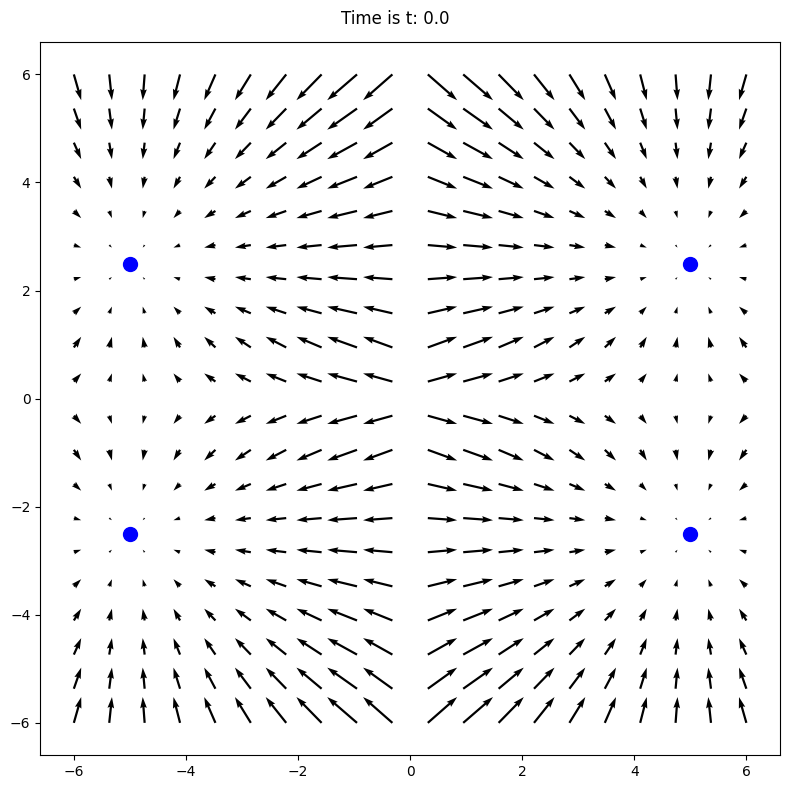

In [7]:
m1 = 5.
m2 = 2.5
t = torch.tensor([.0])
dt = 0.01
sigma = torch.tensor([1.1])
inp, conc = get_vf(m1, m2, t, dt, sigma, n=20, min=-6, max=6, plot=True)


In [19]:
m1 = 5.
m2 = 2.5
sigma = torch.tensor([1.])
dt = 0.01
n = 25
min_val = -6
max_val = 6
# Create a list to store images
images = []
# Generate 100 values of t from 0 to 1
t_values = torch.flip(torch.linspace(0,2., steps=100),dims=[0])
for t_value in tqdm(t_values):
    t = torch.tensor([t_value])
    inp, conc = get_vf(m1, m2, t, dt, sigma, n=n, min=min_val, max=max_val)
    # Plot the function
    plt.figure()
    plt.quiver(inp[:,:,0],inp[:,:,1],conc[:,:,0],conc[:,:,1])
    plt.scatter(m1, m2, color='b', s=100, label='Point (0, 5)')
    plt.scatter(m1, -m2, color='b', s=100, label='Point (0, 5)')
    plt.scatter(-m1, m2, color='b', s=100, label='Point (0, 5)')
    plt.scatter(-m1, -m2, color='b', s=100, label='Point (0, 5)')
    plt.title(f't = {t_value:.2f}')
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    
    # Save the plot to a temporary file
    plt_path = f'plot_fold/temp_{t_value:.2f}.png'
    plt.savefig(plt_path)
    plt.close()
    
    # Append the image to the list
    images.append(imageio.imread(plt_path))
# Create a GIF
imageio.mimsave('function_animation.gif', images, duration=0.05)

100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


## Only score

In [8]:
def compute_cfg(x, t, m1, m2, Gamma_t, label=0):
   if label == 0:
      score = -x + (m1+m2) * torch.exp(-t) / Gamma_t
   elif label == 1:
      score = -x + (m1-m2) * torch.exp(-t) / Gamma_t
   elif label == 2:
      score = -x - (m1+m2) * torch.exp(-t) / Gamma_t
   elif label == 3:
      score = -x - (m1-m2) * torch.exp(-t) / Gamma_t
   return score

In [9]:
def get_vf_score(m1_, m2_, t, dt, sigma, n=10, min=-5, max=5, label=0, plot=False):
    m1 = torch.tensor([m1_,0.])
    m2 = torch.tensor([0., m2_])
    Gamma_t = sigma**2*torch.exp(-2*t) + dt
    x = torch.linspace(min, max, steps=n)
    y = torch.linspace(min, max, steps=n)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    inp = torch.stack((xx, yy), dim=-1)
    inp = inp.reshape(-1, 2)

    conc = []
    for inp_ in inp:
        conc.append(compute_cfg(inp_, t, m1, m2, Gamma_t, label))

    conc = torch.stack(conc).reshape(n, n, 2).detach().numpy()
    inp = inp.reshape(n, n, 2).detach().numpy()
    
    if plot:
        print(Gamma_t)
        plt.figure(figsize=(12, 12))
        plt.quiver(inp[:,:,0],inp[:,:,1],conc[:,:,0],conc[:,:,1])
        plt.scatter(m1_, m2_, color='b', s=100, label='Point (0, 5)')
        plt.scatter(m1_, -m2_, color='b', s=100, label='Point (0, 5)')
        plt.scatter(-m1_, m2_, color='b', s=100, label='Point (0, 5)')
        plt.scatter(-m1_, -m2_, color='b', s=100, label='Point (0, 5)')
        plt.show()
    return inp, conc

tensor([0.0283])


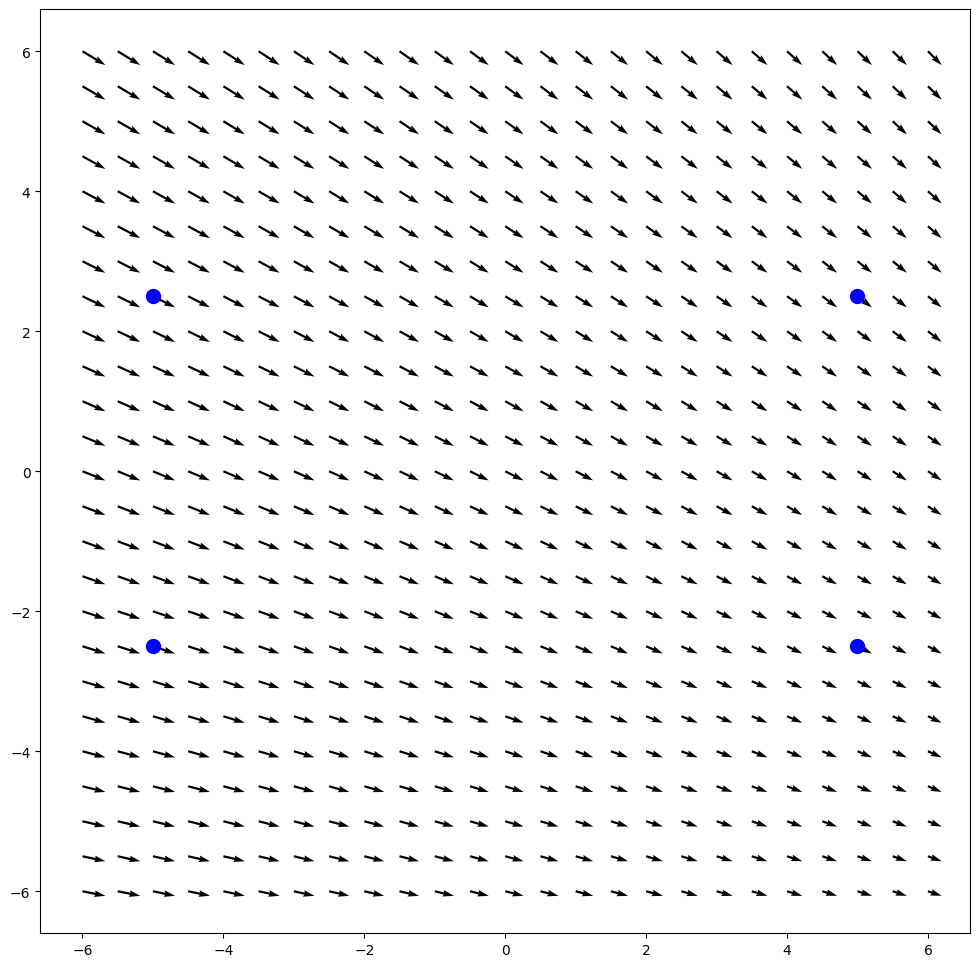

In [18]:
m1 = 5.
m2 = 2.5

t = torch.tensor([2.])
dt = 0.01
sigma = torch.tensor([1.])
inp, conc = get_vf_score(m1, m2, t, dt, sigma, n=25, min=-6, max=6, label=1, plot=True)


In [21]:
m1 = 5.
m2 = 2.5
sigma = torch.tensor([1.])
dt = 0.01
n = 25
min_val = -6
max_val = 6
# Create a list to store images
images = []
# Generate 100 values of t from 0 to 1
t_values = torch.flip(torch.linspace(0,2., steps=100),dims=[0])
for t_value in tqdm(t_values):
    t = torch.tensor([t_value])
    inp, conc = get_vf_score(m1, m2, t, dt, sigma, n=n, min=min_val, max=max_val)
    # Plot the function
    plt.figure()
    plt.quiver(inp[:,:,0],inp[:,:,1],conc[:,:,0],conc[:,:,1])
    plt.scatter(m1, m2, color='r', s=100, label='Point (0, 5)')
    plt.scatter(m1, -m2, color='b', s=100, label='Point (0, 5)')
    plt.scatter(-m1, m2, color='b', s=100, label='Point (0, 5)')
    plt.scatter(-m1, -m2, color='b', s=100, label='Point (0, 5)')
    plt.title(f't = {t_value:.2f}')
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    
    # Save the plot to a temporary file
    plt_path = f'plot_fold2/temp_{t_value:.2f}.png'
    plt.savefig(plt_path)
    plt.close()
    
    # Append the image to the list
    images.append(imageio.imread(plt_path))
# Create a GIF
imageio.mimsave('score_animation.gif', images, duration=0.05)

100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


# CFG

In [28]:
def get_vf_cfg(m1_, m2_, t, dt, sigma, omega, n=10, min=-5, max=5, label=0, plot=False):
    m1 = torch.tensor([m1_,0.])
    m2 = torch.tensor([0., m2_])
    Gamma_t = sigma**2*torch.exp(-2*t) + dt
    x = torch.linspace(min, max, steps=n)
    y = torch.linspace(min, max, steps=n)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    inp = torch.stack((xx, yy), dim=-1)
    inp = inp.reshape(-1, 2)

    conc1, conc2 = [], []
    for inp_ in inp:
        conc1.append(compute_cfg(inp_, t, m1, m2, Gamma_t, label))
        conc2.append(compute_S_i_t(inp_, t, m1, m2, Gamma_t))

    conc1 = torch.stack(conc1).reshape(n, n, 2).detach().numpy()
    conc2 = torch.stack(conc2).reshape(n, n, 2).detach().numpy()
    conc = (1+omega)*conc1 - omega*conc2
    inp = inp.reshape(n, n, 2).detach().numpy()
    
    if plot:
        print(Gamma_t)
        plt.figure(figsize=(12, 12))
        plt.quiver(inp[:,:,0],inp[:,:,1],conc[:,:,0],conc[:,:,1])
        plt.scatter(m1_, m2_, color='b', s=100, label='Point (0, 5)')
        plt.scatter(m1_, -m2_, color='b', s=100, label='Point (0, 5)')
        plt.scatter(-m1_, m2_, color='b', s=100, label='Point (0, 5)')
        plt.scatter(-m1_, -m2_, color='b', s=100, label='Point (0, 5)')
        plt.show()
    return inp, conc

tensor([0.8287])


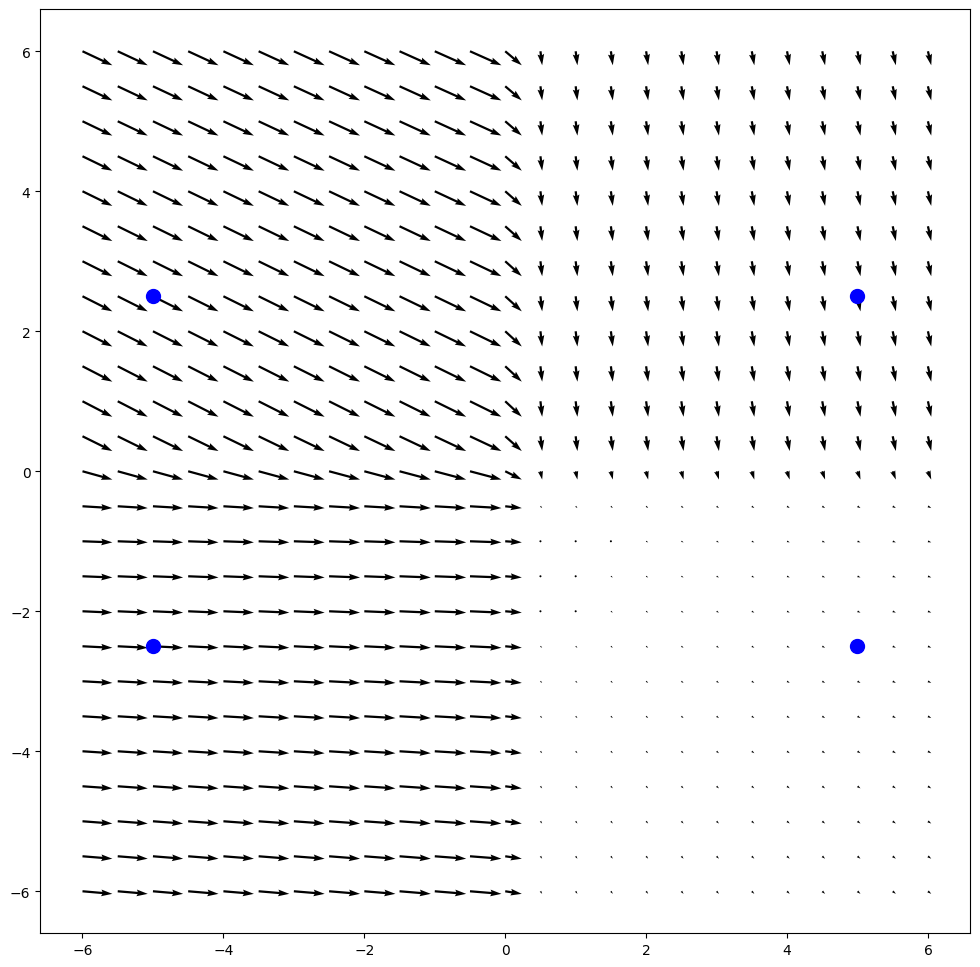

In [27]:
m1 = 5.
m2 = 2.5

t = torch.tensor([.1])
dt = 0.01
sigma = torch.tensor([1.])
omega = 10.5
inp, conc = get_vf_cfg(m1, m2, t, dt, sigma, omega, n=25, min=-6, max=6, label=1, plot=True)

## All three

In [41]:
def get_all_three(m1_, m2_, t, dt, sigma, omega, n=10, min=-5, max=5, label=0, plot=False):
    m1 = torch.tensor([m1_,0.])
    m2 = torch.tensor([0., m2_])
    Gamma_t = sigma**2*torch.exp(-2*t) + dt
    x = torch.linspace(min, max, steps=n)
    y = torch.linspace(min, max, steps=n)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    inp = torch.stack((xx, yy), dim=-1)
    inp = inp.reshape(-1, 2)

    conc1, conc2 = [], []
    for inp_ in inp:
        conc1.append(compute_cfg(inp_, t, m1, m2, Gamma_t, label))
        conc2.append(compute_S_i_t(inp_, t, m1, m2, Gamma_t))

    conc1 = torch.stack(conc1).reshape(n, n, 2).detach().numpy()
    conc2 = torch.stack(conc2).reshape(n, n, 2).detach().numpy()
    conc = (1+omega)*conc1 - omega*conc2
    inp = inp.reshape(n, n, 2).detach().numpy()
    
    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create 3 subplots side by side
        for ax, c in zip(axes, [conc1, conc2, conc]):
            # for a specific t value rounded to two digits
            ax.set_title(['Conditional vec. field, t= %.2f' % t, 'Unconditional vec. field, t= %.2f' % t, 'CFG vec. field, t= %.2f' % t][axes.tolist().index(ax)])
            ax.quiver(inp[:, :, 0], inp[:, :, 1], c[:, :, 0], c[:, :, 1])
            ax.scatter(m1_, m2_, color='b', s=100)
            ax.scatter(m1_, -m2_, color='r', s=100, label='Chosen class')
            ax.scatter(-m1_, m2_, color='b', s=100)
            ax.scatter(-m1_, -m2_, color='b', s=100)
            ax.legend()
        plt.show()
    return inp, conc

In [121]:
def get_all_three(m1_, m2_, t, dt, sigma, omega, n=10, min=-5, max=5, label=1, plot=False):
    m1 = torch.tensor([m1_, 0.])
    m2 = torch.tensor([0., m2_])
    Gamma_t = sigma**2 * torch.exp(-2 * t) + dt
    x = torch.linspace(min, max, steps=n)
    y = torch.linspace(min, max, steps=n)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    inp = torch.stack((xx, yy), dim=-1)
    inp = inp.reshape(-1, 2)
    conc1, conc2 = [], []
    for inp_ in inp:
        conc1.append(compute_cfg(inp_, t, m1, m2, Gamma_t, label))
        conc2.append(compute_S_i_t(inp_, t, m1, m2, Gamma_t))
    conc1 = torch.stack(conc1).reshape(n, n, 2).detach().numpy()
    conc2 = torch.stack(conc2).reshape(n, n, 2).detach().numpy()
    conc = (1 + omega) * conc1 - omega * conc2
    inp = inp.reshape(n, n, 2).detach().numpy()
    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create 3 subplots side by side
        for ax, c in zip(axes, [conc1, conc2, conc]):
            ax.set_title(['Conditional vec. field, t= %.2f' % t, 'Unconditional vec. field, t= %.2f' % t, 'CFG vec. field, t= %.2f' % t][axes.tolist().index(ax)])
            ax.quiver(inp[:, :, 0], inp[:, :, 1], c[:, :, 0], c[:, :, 1])
            ax.scatter(m1_, m2_, color='b', s=25)
            ax.scatter(m1_, -m2_, color='r', s=25, label='Chosen class')
            ax.scatter(-m1_, m2_, color='b', s=25)
            ax.scatter(-m1_, -m2_, color='b', s=25)
            # Add contours of 2D Gaussian
            for mean in [np.array([5, 2.5]), np.array([-5, 2.5]), np.array([-5, -2.5])]:
                circle1 = plt.Circle(mean, 1., color='b', fill=False)
                ax.add_patch(circle1)
            circle1 = plt.Circle((5,-2.5), 1., color='r', fill=False)
            ax.add_patch(circle1)
            ax.legend()
        plt.suptitle("CFG with $\omega$ = %.2f" % omega)
        plt.show()
    return inp, conc1, conc2, conc

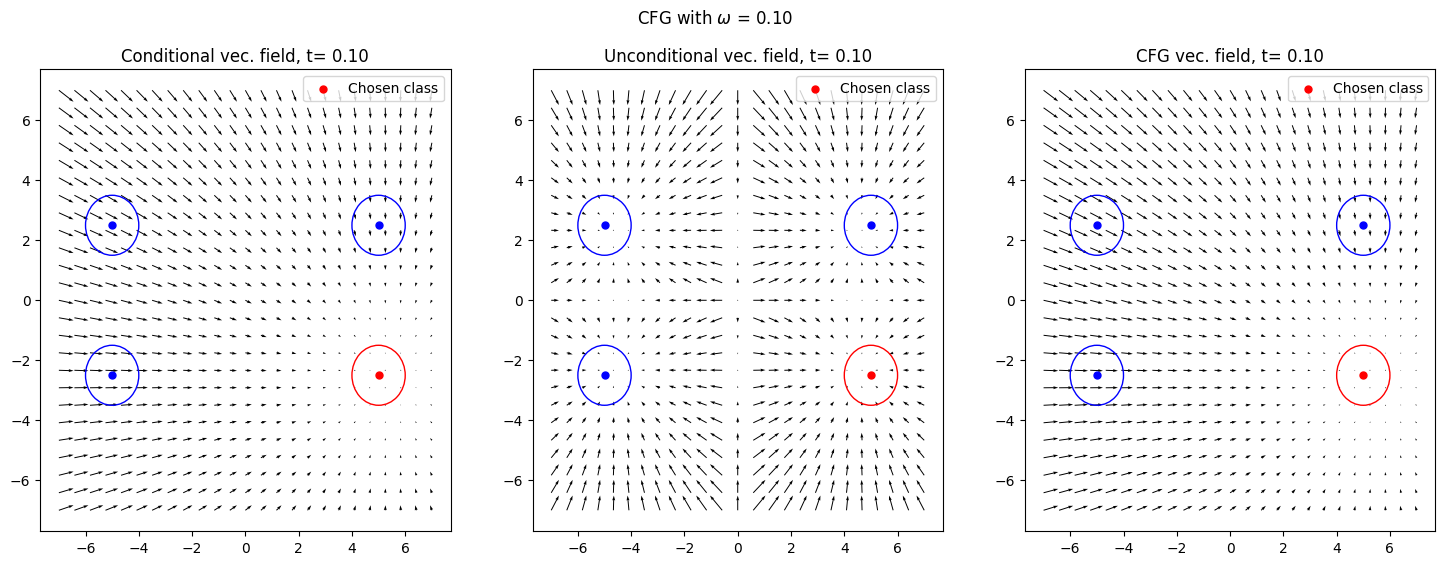

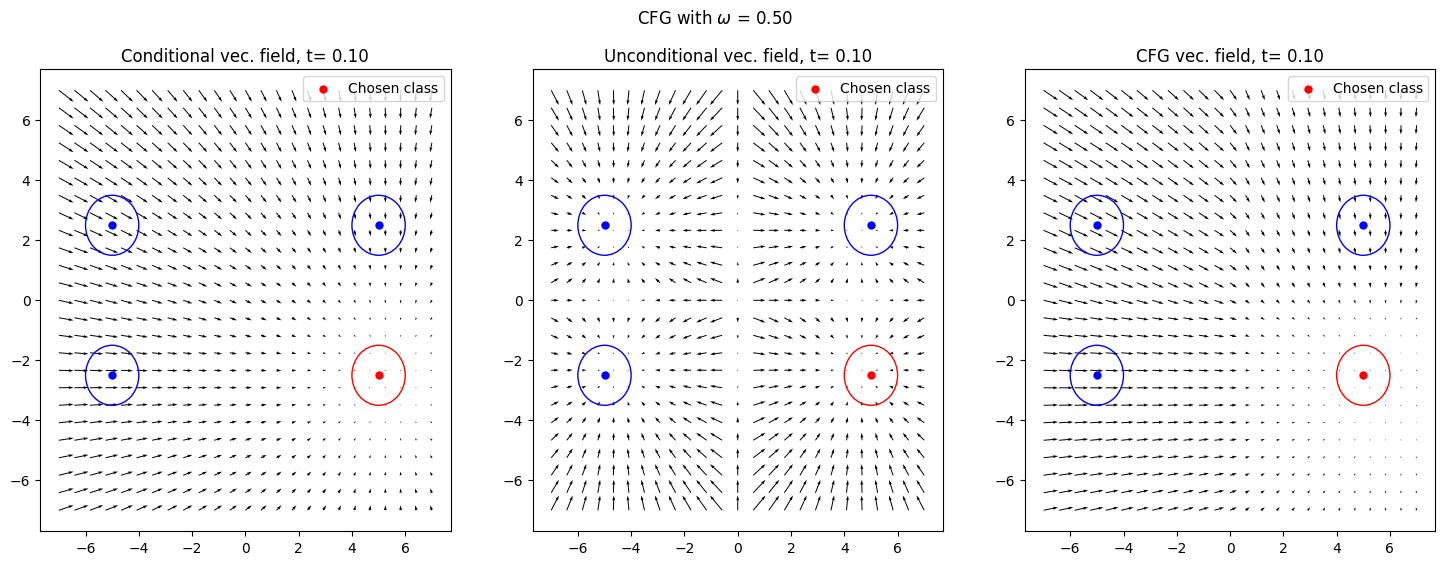

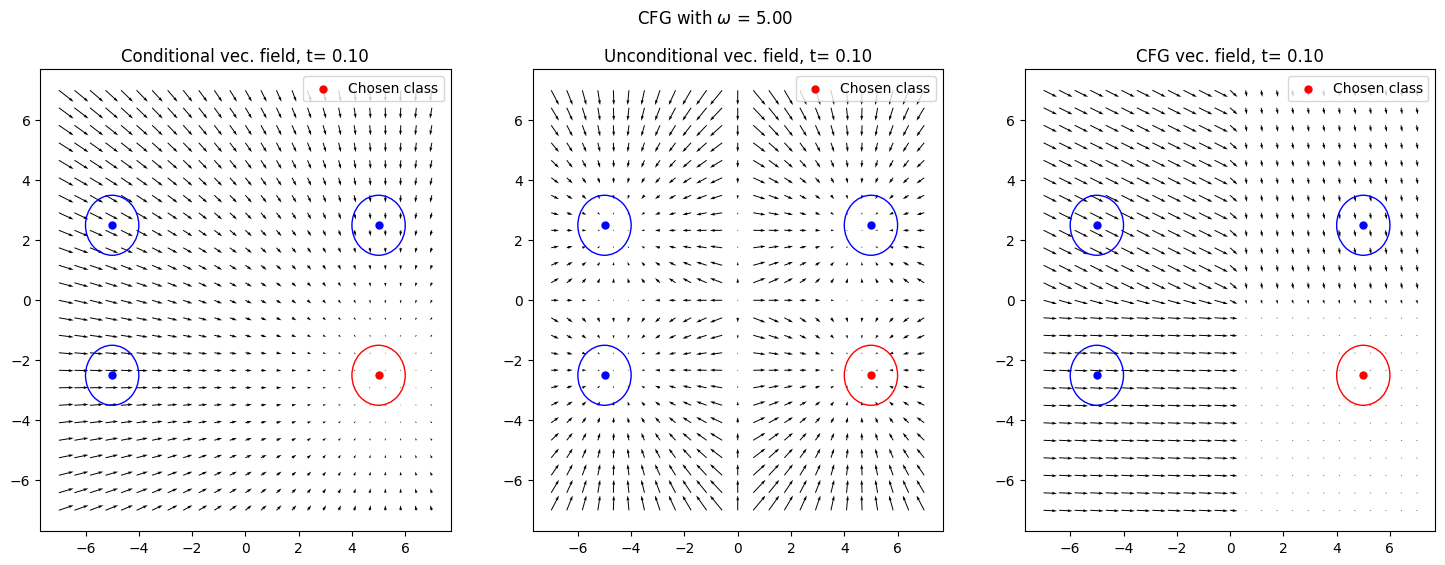

In [128]:
m1 = 5.
m2 = 2.5

t = torch.tensor([0.1])
dt = 0.01
sigma = torch.tensor([1.])
omega = .1
_, _, _, _= get_all_three(m1, m2, t, dt, sigma, omega, n=25, min=-7, max=7, plot=True)
_, _, _, _= get_all_three(m1, m2, t, dt, sigma, .5, n=25, min=-7, max=7, plot=True)
_, _, _, _= get_all_three(m1, m2, t, dt, sigma, 5., n=25, min=-7, max=7, plot=True)

In [131]:
m1 = 5.
m2 = 2.5
sigma = torch.tensor([1.])
dt = 0.01
n = 25
omega = 5.
min_val = -7
max_val = 7
# Create a list to store images
images = []
# Generate 100 values of t from 0 to 1
t_values = torch.flip(torch.linspace(0,2., steps=100),dims=[0])
for t_value in tqdm(t_values):
    t = torch.tensor([t_value])
    inp, conc1, conc2, conc = get_all_three(m1, m2, t, dt, sigma, omega, n=n, min=min_val, max=max_val)
    # Plot the function
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create 3 subplots side by side
    for ax, c in zip(axes, [conc1, conc2, conc]):
        ax.set_title(['Conditional vec. field, t= %.2f' % t, 'Unconditional vec. field, t= %.2f' % t, 'CFG vec. field, t= %.2f' % t][axes.tolist().index(ax)])
        ax.quiver(inp[:, :, 0], inp[:, :, 1], c[:, :, 0], c[:, :, 1])
        ax.scatter(m1, m2, color='b', s=25)
        ax.scatter(m1, -m2, color='r', s=25, label='Chosen class')
        ax.scatter(-m1, m2, color='b', s=25)
        ax.scatter(-m1, -m2, color='b', s=25)
        # Add contours of 2D Gaussian
        for mean in [np.array([5, 2.5]), np.array([-5, 2.5]), np.array([-5, -2.5])]:
            circle1 = plt.Circle(mean, 1., color='b', fill=False)
            ax.add_patch(circle1)
        circle1 = plt.Circle((5,-2.5), 1., color='r', fill=False)
        ax.add_patch(circle1)
        ax.legend()
    # Save the plot to a temporary file
    plt_path = f'plot_final/temp_{t_value:.2f}.png'
    fig.suptitle("CFG with $\omega$ = %.2f" % omega)
    plt.savefig(plt_path)
    plt.close()
    
    # Append the image to the list
    images.append(imageio.imread(plt_path))
# Create a GIF
imageio.mimsave('cfg_animation_w_'+str(omega)+'.gif', images, duration=0.05)

100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


# New thing

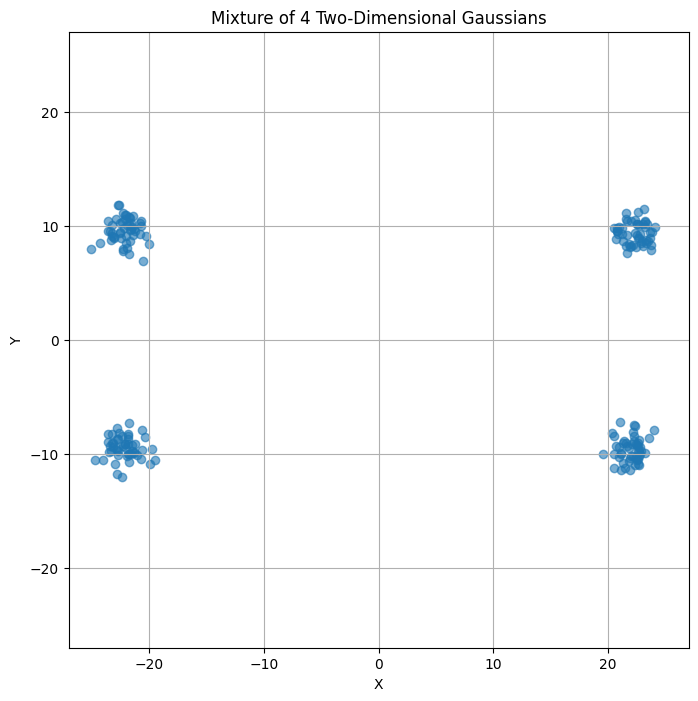

In [246]:
m1, m2 = 22., 9.5
means = torch.tensor([[m1, m2], [-m1, m2], [m1, -m2], [-m1, -m2]])
covariances = torch.tensor([[[1., 0.], [0., 1.]]] * 4)  # Shared covariance
weights = torch.tensor([0.25, 0.25, 0.25, 0.25])  # Equal weights
# Number of samples
num_samples = 200
# Sample from each Gaussian
samples = []
for mean, cov, weight in zip(means, covariances, weights):
    num_samples_gaussian = int(num_samples * weight)
    distribution = torch.distributions.MultivariateNormal(mean, cov)
    samples_gaussian = distribution.sample((num_samples_gaussian,))
    samples.append(samples_gaussian)
# Concatenate all samples
all_samples = torch.cat(samples)
# Plot the samples
plt.figure(figsize=(8, 8))
plt.scatter(all_samples[:, 0].numpy(), all_samples[:, 1].numpy(), alpha=0.6)
plt.title('Mixture of 4 Two-Dimensional Gaussians')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.grid(True)
plt.show()


In [120]:
all_samples.shape

torch.Size([200, 2])

In [180]:
m1 = torch.tensor([22.,0.])
m2 = torch.tensor([0., 9.5])
dt = 0.01
sigma = torch.tensor([6.])
n = 25
min_val = -27
max_val = 27

t = torch.tensor([0.])

s_cfg = []
x_prev = all_samples

images_new = []
for it in tqdm(range(200)):
    t += it*dt
    x_cur = []
    for x in x_prev:
        Gamma_t = sigma**2*torch.exp(-2*t) + dt
        s_cfg = compute_S_i_t(x, t, m1, m2, Gamma_t)
        eta = torch.randn_like(x) * torch.sqrt(torch.tensor(2*dt))
        x_new = x + 2 * dt * s_cfg# + eta
        x_cur.append(x_new)
    x_cur = torch.stack(x_cur)
    plt.figure()
    plt.scatter(x_cur[:,0].detach().numpy(), x_cur[:,1].detach().numpy(), alpha=0.6)
    plt_path = f'plot_fold2/temp_{t_value:.2f}.png'
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.savefig(plt_path)
    plt.close()
    images_new.append(imageio.imread(plt_path))
    
    x_prev = x_cur

imageio.mimsave('sampling_animation.gif', images_new, duration=0.05)

100%|██████████| 200/200 [00:26<00:00,  7.67it/s]
